# Etap 3

## Spis treści:
* [Wstęp](#wstep)

* [Zależności i definicje](#zf)

* [Prezentacja zbiorów danych](#datasets)

* [Dostrajanie parametrów](#tuning)
    * [Rozmiar i liczba gęstych warstw](#dense)
    * [Współczynnik uczenia](#learning-rate)
    * [SGD - Pęd](#momentum)
    * [Batch size](#batch)
    
* [Porównanie wyników na różnych zbiorach](#comp)

# Wstęp <a class="anchor" id="wstep"></a>

W tym dokumencie zbadano wpływ wybranych parametrów na jakoś klasyfikacji modelu oraz prędkość uczenia sieci neuronowej.
Po dokonaniu wstępnego strojenia parametrów przeprowadzono testy na zbiorach danych o różnym poziomie skomplikowania.

# Zależności i definicje <a class="anchor" id="zf"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import math

def show_test_acc(result_paths, labels, n_tests):
    file_name = '/trafnosc_test.csv'
    data = []
    for path in result_paths:
        test_acc = np.loadtxt(path + file_name, delimiter=',')
        data.append(test_acc)

    df = pd.DataFrame(data)
    df = df.T 

    df.columns = labels
    
    index_names = []
    for i in range(1, n_tests+1):
        index_names.append(f'Trafność {i}')

    df.index = index_names
    df.loc['Średnia arytmetyczna'] = df.mean()
    df.columns.name = 'Trafność na zbiorze testowym'
    display(df)

def show_acc_loss_chart(path, n_epochs, n_tests, label):
    file_name_acc = '/przebieg_treningu-trafnosc.csv'
    file_name_loss = '/przebieg_treningu-funkcja-straty.csv'

    cols = np.arange(1, n_epochs+1)
    df_acc = pd.read_csv(path + file_name_acc, names=cols, engine='python')
    df_loss = pd.read_csv(path + file_name_loss, names=cols, engine='python')
    acc_history = df_acc.to_numpy()
    loss_history = df_loss.to_numpy()

    fig=plt.figure(figsize=(15,5))

    plt.subplot(1, 2, 1)
    for i in range(n_tests):
        plt.plot(cols, acc_history[i])

    plt.grid()
    plt.title('Trafność modelu na zbiorze walidacyjnym - ' + label)
    plt.ylabel('Trafność')
    plt.xlabel('Epoki')

    plt.subplot(1, 2, 2)
    for i in range(n_tests):
        plt.plot(cols, loss_history[i])

    plt.grid()
    plt.title('Funkcji straty na zbiorze walidacyjnym - ' + label)
    plt.ylabel('Wartość funkcji straty')
    plt.xlabel('Epoki')
    plt.show()
    
def show_all_acc_loss_charts(result_paths, n_epochs, n_tests, labels):
    for path, label in zip(result_paths, labels):
        show_acc_loss_chart(path, n_epochs, n_tests, label)

# Prezentacja zbiorów danych <a class="anchor" id="datasets"></a>

Do testów wykorzystano 9 różnych zbiorów danych.

Zbiory `Realistyczne z odległości bez tła` oraz `Realistyczne z odległości z tłem` posiadają po 1250 obrazów dla każdej z klas. Zostały one wygenerowane w taki sposób, aby elementy na nich zawarte były widoczne w całości. Kąt, pod którym wykonano zdjęcie nie jest stały.

Wszystkie pozostałe zbiory posiadają na obrazach obiekty w identycznym położeniu. Dla każdej z klas wygenerowano 1000 obrazów.


- Uproszczone, czarne tło

<table><tr>
<td> <img src="help_img/sb1.png" style="width: 250px;"/> </td>
<td> <img src="help_img/sb2.png" style="width: 250px;"/> </td>
</tr></table>

- Uproszczone, białe tło

<table><tr>
<td> <img src="help_img/sw1.png" style="width: 250px;"/> </td>
<td> <img src="help_img/sw2.png" style="width: 250px;"/> </td>
</tr></table>

- Krawędzie, czarne tło

<table><tr>
<td> <img src="help_img/wb1.png" style="width: 250px;"/> </td>
<td> <img src="help_img/wb2.png" style="width: 250px;"/> </td>
</tr></table>

- Krawędzie, białe tło

<table><tr>
<td> <img src="help_img/ww1.png" style="width: 250px;"/> </td>
<td> <img src="help_img/ww2.png" style="width: 250px;"/> </td>
</tr></table>

- Realistyczne z odległości bez tła

<table><tr>
<td> <img src="help_img/nobg1.png" style="width: 250px;"/> </td>
<td> <img src="help_img/nobg2.png" style="width: 250px;"/> </td>
</tr></table>

- Realistyczne z odległości z tłem

<table><tr>
<td> <img src="help_img/bg1.png" style="width: 250px;"/> </td>
<td> <img src="help_img/bg2.png" style="width: 250px;"/> </td>
</tr></table>

- Realistyczne bez tła i tekstury

<table><tr>
<td> <img src="help_img/r11.png" style="width: 250px;"/> </td>
<td> <img src="help_img/r12.png" style="width: 250px;"/> </td>
</tr></table>

- Realistyczne bez tła z teksturą

<table><tr>
<td> <img src="help_img/r21.png" style="width: 250px;"/> </td>
<td> <img src="help_img/r22.png" style="width: 250px;"/> </td>
</tr></table>

- Realistyczne z tłem i teksturą

<table><tr>
<td> <img src="help_img/r31.png" style="width: 250px;"/> </td>
<td> <img src="help_img/r32.png" style="width: 250px;"/> </td>
</tr></table>

# Dostrajanie parametrów <a class="anchor" id="tuning"></a>

W celu poprawienia wyników oraz przyspieszenia procesu uczenia przygotowano wstępny dobór parametrów.
Testy podczas dostrajania parametrów były przeprowadzane na zbiorze 'Realistyczne z odległości bez tła'.

Dodatkowym usprawnieniem było wprowadzenie podział danych na trzy podzbiory: treningowy, walidacyjny oraz testowy w stosunku 70:15:15. Zbiór treningowy wykorzystywany jest jako dane wejściowe do uczenia sieci neuronowej. Zbiór walidacyjny wykorzystywany jest jedynie do oceniania postępów treningu. Na podstawie oceny otrzymanej w ten sposób można zakończyć uczenie w momencie, gdy kolejne epoki nie poprawiają wyników. Zbiór testowy wykorzystywany jest do finalnego przetestowania jakości modelu po zakończeniu uczenia.

## Rozmiar i liczba gęstych warstw <a class="anchor" id="dense"></a>

![](help_img/architektura.png)

<span style="font-family:Papyrus; font-size:1em;">
Źródło: https://aigeekprogrammer.com/pl/konwolucyjne-sieci-neuronowe-klasyfikacja-obrazow-czesc-2/
</span>

Wraz ze zwiększeniem rozmiarów pojedynczej warstwy ukrytej odnotowano wzrost trafności. Dodanie drugie warstwy nie poprawiło w znacznym stopniu jakości modelu.

Do dalszych testów ustawiono rozmiar warstwy gęstej na 512. Dla wartości 1024 otrzymywano ostrzeżenia o przekraczaniu dostępnych zasobów pamięci.

Trafność na zbiorze testowym,32,64,128,256,512,512x2,1024
Trafność 1,0.704787,0.799202,0.795213,0.788564,0.821809,0.827128,0.832447
Trafność 2,0.252660,0.767287,0.799202,0.811170,0.815160,0.809840,0.819149
Trafność 3,0.684840,0.787234,0.803191,0.821809,0.809840,0.817819,0.817819
Średnia arytmetyczna,0.547429,0.784574,0.799202,0.807181,0.815603,0.818262,0.823138


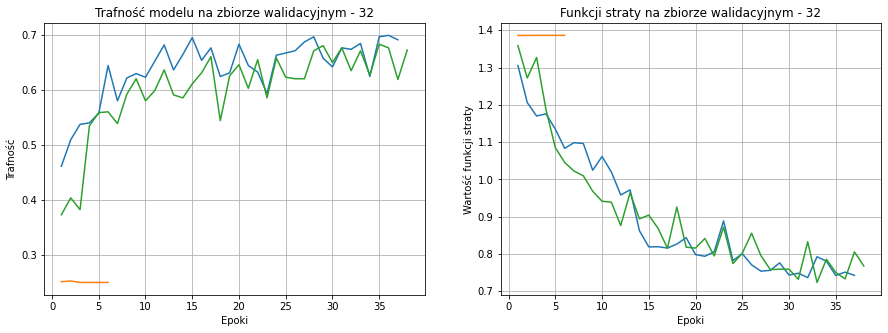

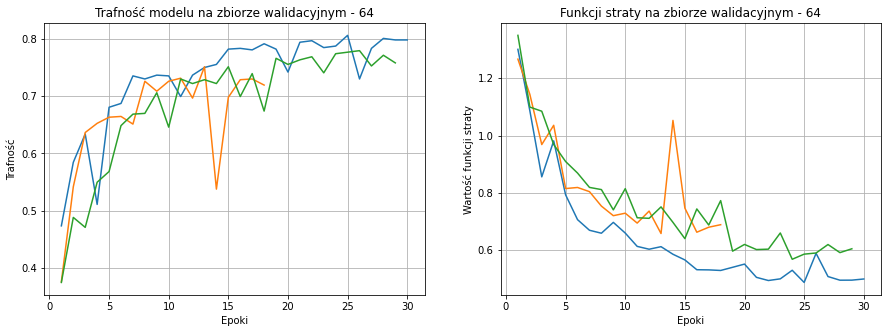

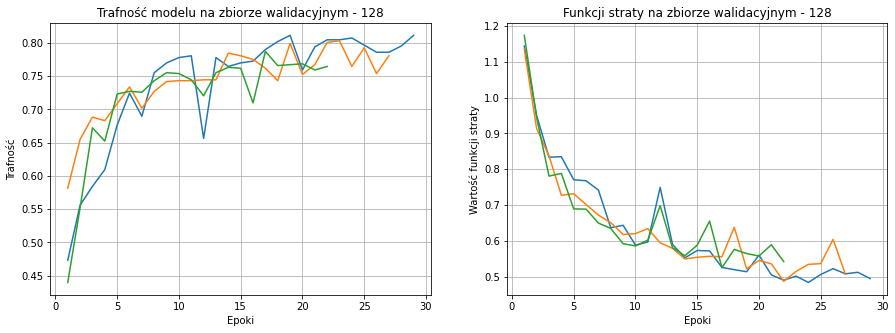

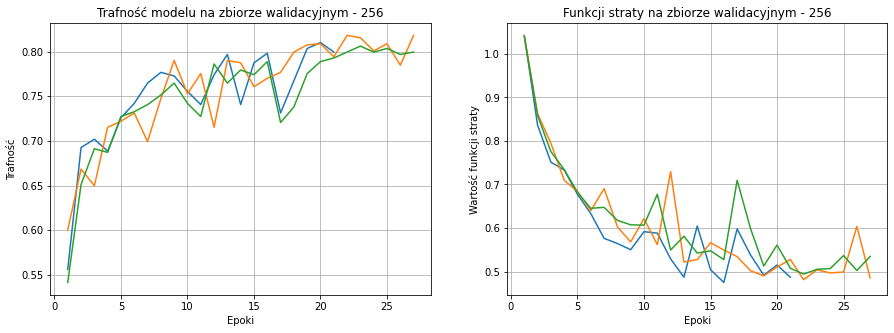

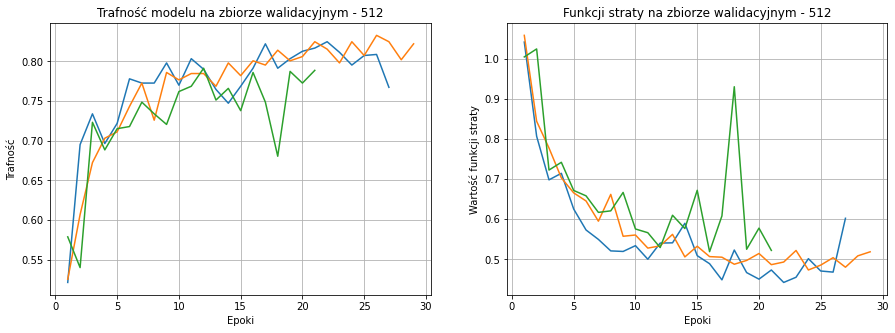

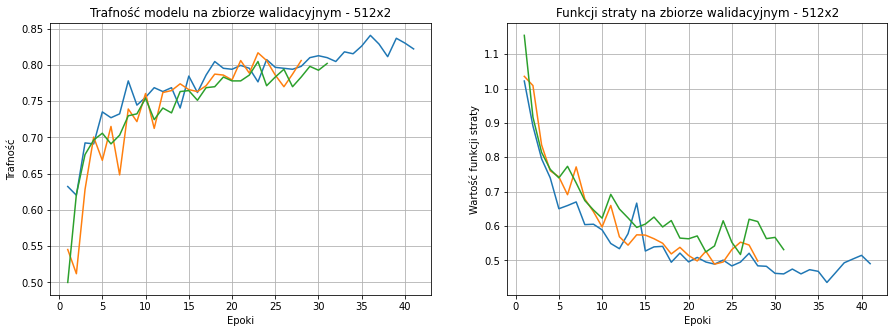

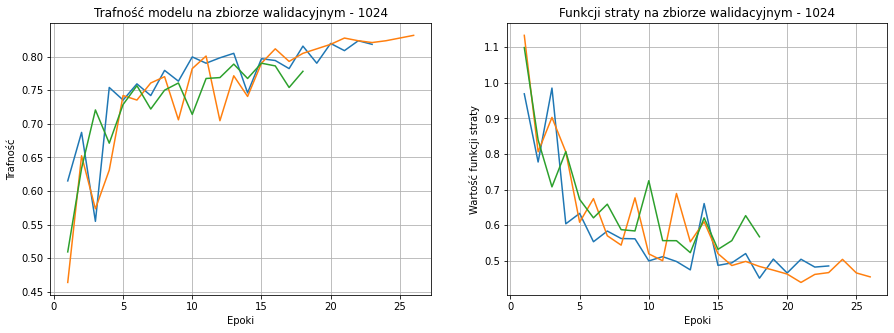

In [2]:
result_paths = ['results/STL_RENDERS_SIMPLE_NOBG_dense32', 
               'results/STL_RENDERS_SIMPLE_NOBG_dense64', 
               'results/STL_RENDERS_SIMPLE_NOBG_dense128', 
               'results/STL_RENDERS_SIMPLE_NOBG_dense256',
               'results/STL_RENDERS_SIMPLE_NOBG_dense512',
               'results/STL_RENDERS_SIMPLE_NOBG_dense512_x2',
               'results/STL_RENDERS_SIMPLE_NOBG_dense1024'
               ]
labels = ['32', '64', '128', '256', '512', '512x2', '1024']
show_test_acc(result_paths, labels, 3)
show_all_acc_loss_charts(result_paths, 50, 3, labels)

## Współczynnik uczenia <a class="anchor" id="learning-rate"></a>

Trafność na zbiorze testowym,0.1,0.01,0.001,0.0001
Trafność 1,0.375000,0.805851,0.837766,0.787234
Trafność 2,0.283245,0.816489,0.817819,0.769947
Trafność 3,0.353723,0.824468,0.833777,0.783245
Średnia arytmetyczna,0.337323,0.815603,0.829787,0.780142


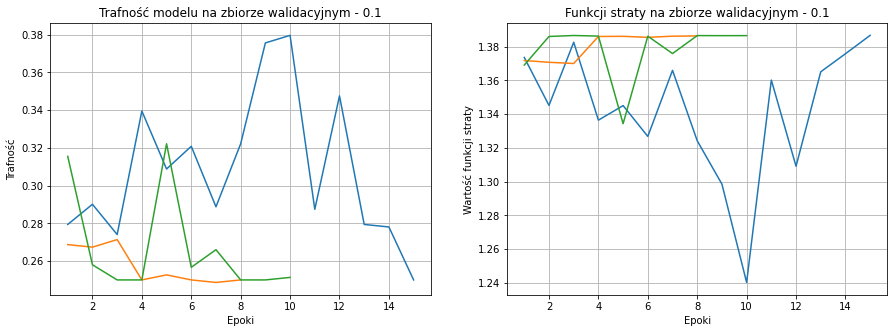

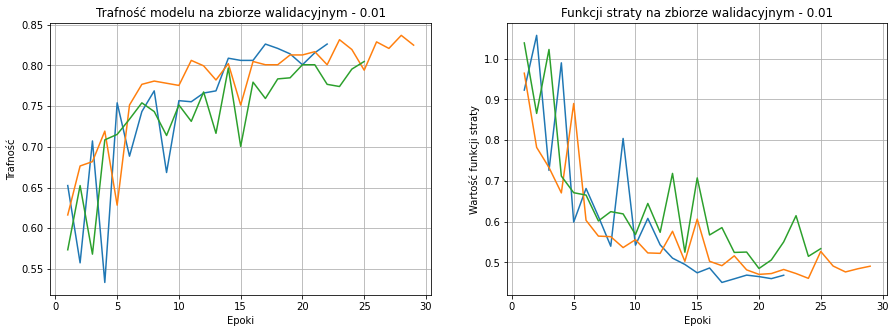

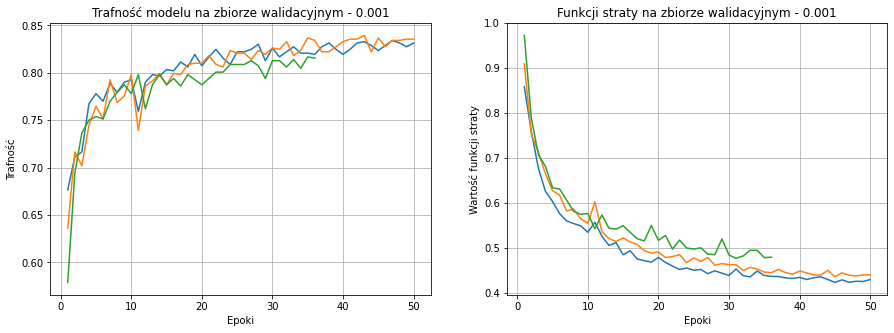

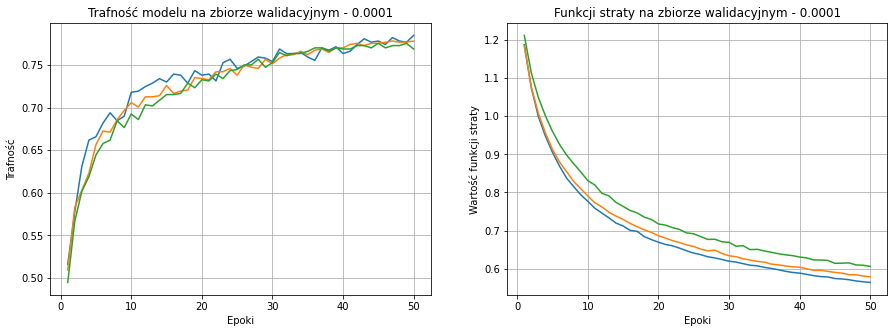

In [3]:
result_paths = ['results/STL_RENDERS_SIMPLE_NOBG_learning_rate_0.1',
                'results/STL_RENDERS_SIMPLE_NOBG_learning_rate_0.01',
                'results/STL_RENDERS_SIMPLE_NOBG_learning_rate_0.001',
                'results/STL_RENDERS_SIMPLE_NOBG_learning_rate_0.0001'
               ]
labels = ['0.1', '0.01', '0.001', '0.0001']
show_test_acc(result_paths, labels, 3)
show_all_acc_loss_charts(result_paths, 50, 3, labels)

## SGD - Pęd (momentum) <a class="anchor" id="momentum"></a>

Trafność na zbiorze testowym,0.1,0.3,0.5,0.7,0.9
Trafność 1,0.835106,0.839096,0.839096,0.819149,0.825798
Trafność 2,0.821809,0.820479,0.820479,0.832447,0.827128
Trafność 3,0.837766,0.831117,0.825798,0.827128,0.835106
Średnia arytmetyczna,0.831560,0.830230,0.828457,0.826241,0.829344


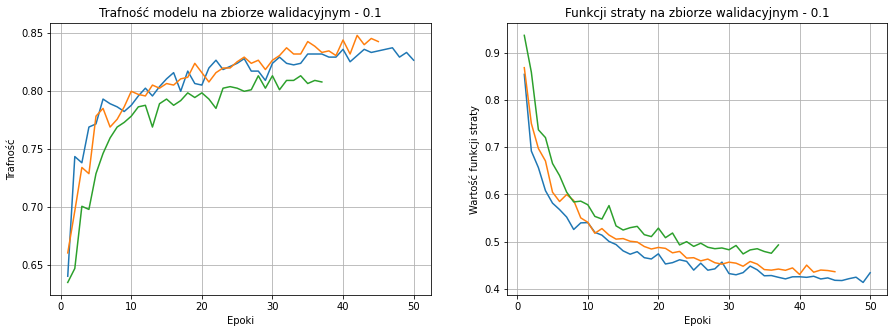

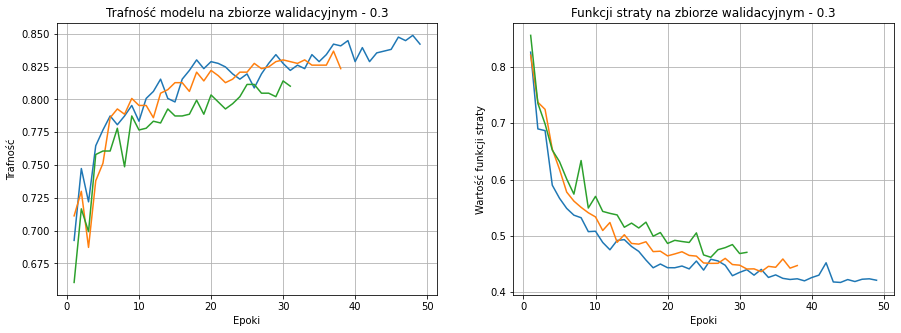

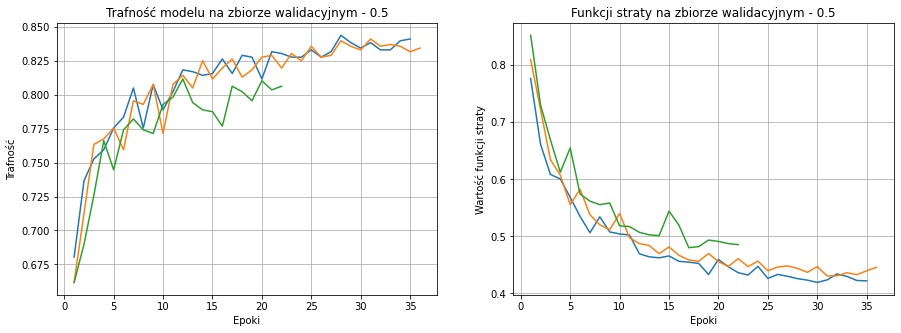

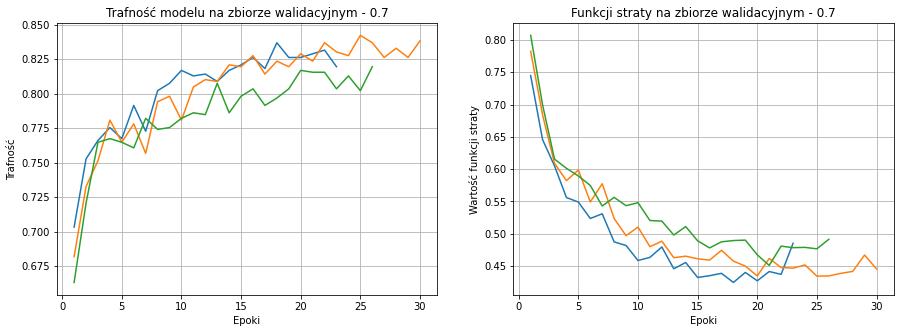

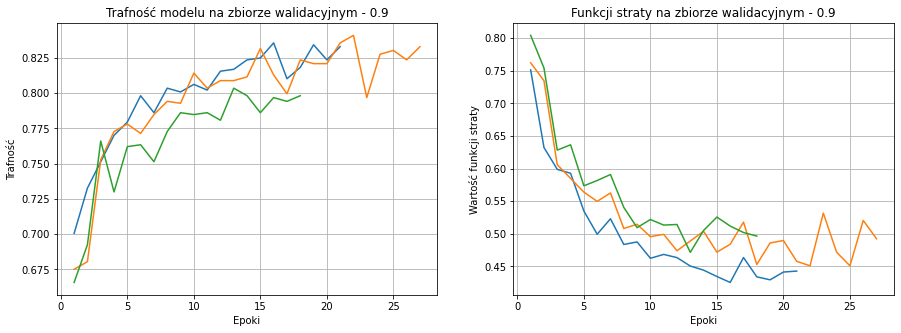

In [4]:
result_paths = ['results/STL_RENDERS_SIMPLE_NOBG_momentum_0.1',
                'results/STL_RENDERS_SIMPLE_NOBG_momentum_0.3',
                'results/STL_RENDERS_SIMPLE_NOBG_momentum_0.5',
                'results/STL_RENDERS_SIMPLE_NOBG_momentum_0.7',
                'results/STL_RENDERS_SIMPLE_NOBG_momentum_0.9'
               ]
labels = ['0.1', '0.3', '0.5', '0.7', '0.9']
show_test_acc(result_paths, labels, 3)
show_all_acc_loss_charts(result_paths, 50, 3, labels)

## Batch size - liczba próbek podawanych jednocześnie<a class="anchor" id="batch"></a>

Trafność na zbiorze testowym,16,32,64
Trafność 1,0.812500,0.796543,0.809840
Trafność 2,0.788564,0.784574,0.823138
Trafność 3,0.820479,0.821809,0.829787
Średnia arytmetyczna,0.807181,0.800975,0.820922


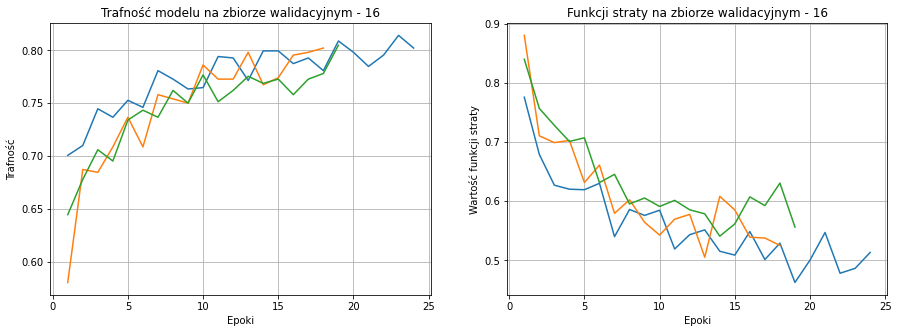

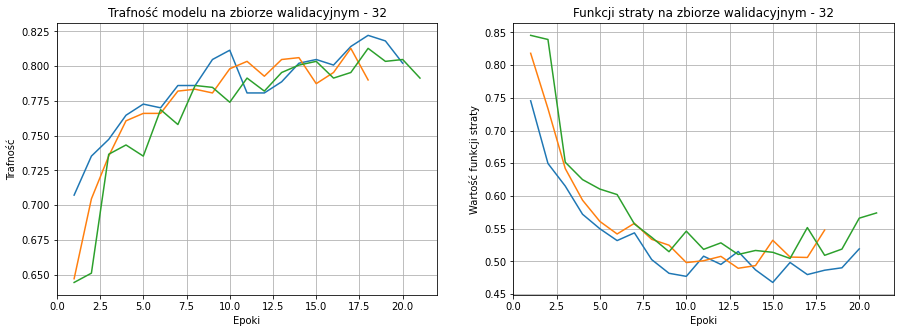

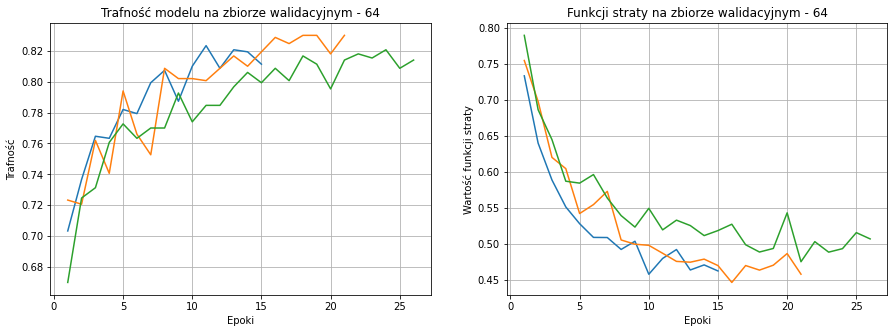

In [5]:
result_paths = ['results/STL_RENDERS_SIMPLE_NOBG_batch_size_16',
                'results/STL_RENDERS_SIMPLE_NOBG_batch_size_32',
                'results/STL_RENDERS_SIMPLE_NOBG_batch_size_64'
               ]
labels = ['16', '32', '64']
show_test_acc(result_paths, labels, 3)
show_all_acc_loss_charts(result_paths, 50, 3, labels)

# Porównanie wyników na różnych zbiorach <a class="anchor" id="comp"></a>

Trafność na zbiorze testowym,"Uproszczone, czarne tło","Uproszczone, białe tło","Krawędzie, czarne tło","Krawędzie, białe tło",Realistyczne z odległości bez tła,Realistyczne z odległości z tłem,Realistyczne bez tła i tekstury,Realistyczne bez tła z teksturą,Realistyczne z tłem i teksturą
Trafność 1,0.976667,0.978333,0.983333,0.986667,0.829787,0.695479,0.970000,0.948333,0.890000
Trafność 2,0.985000,0.991667,0.991667,0.988333,0.819149,0.691489,0.990000,0.941667,0.908333
Trafność 3,0.988333,0.988333,0.988333,0.985000,0.836436,0.686170,0.981667,0.946667,0.893333
Trafność 4,0.983333,0.986667,0.981667,0.990000,0.832447,0.675532,0.980000,0.951667,0.911667
Trafność 5,0.990000,0.991667,0.988333,0.993333,0.799202,0.688830,0.990000,0.925000,0.901667
Średnia arytmetyczna,0.984667,0.987333,0.986667,0.988667,0.823404,0.687500,0.982333,0.942667,0.901000


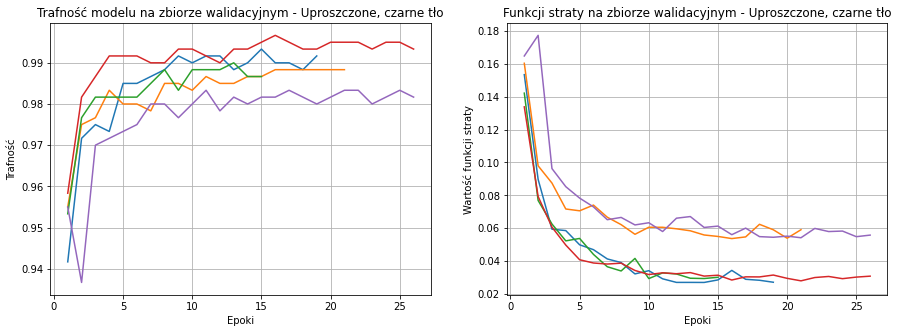

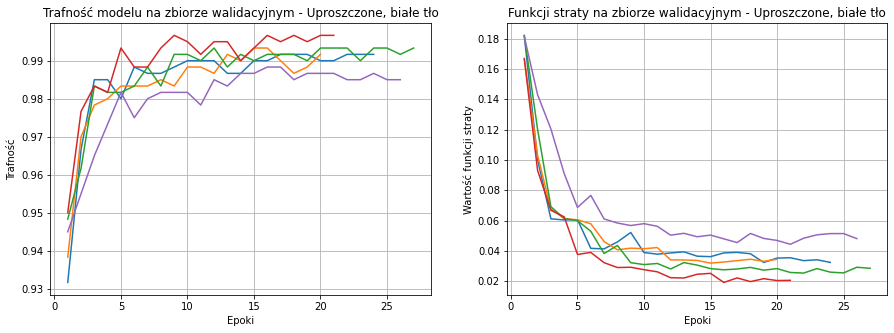

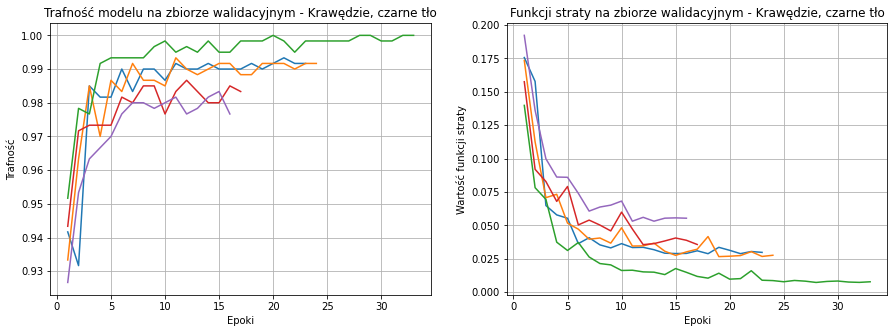

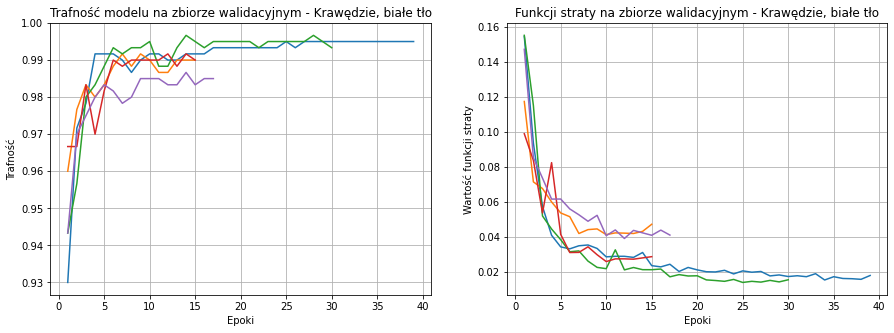

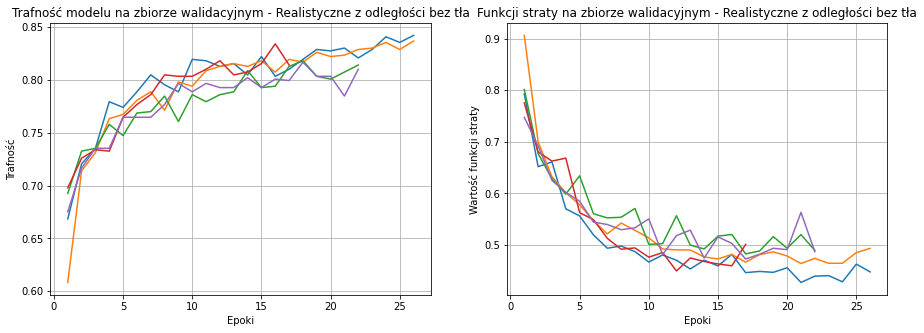

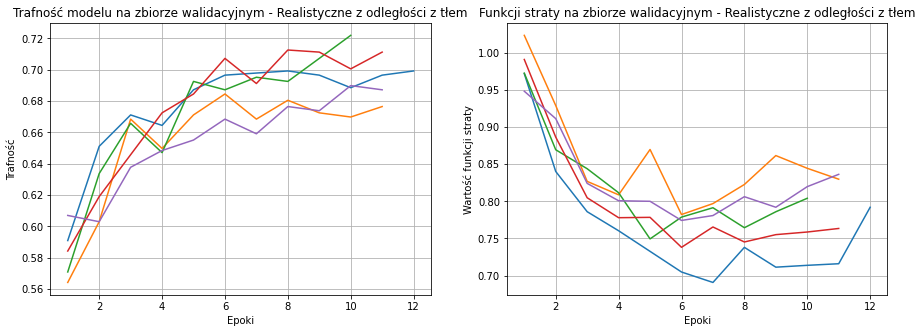

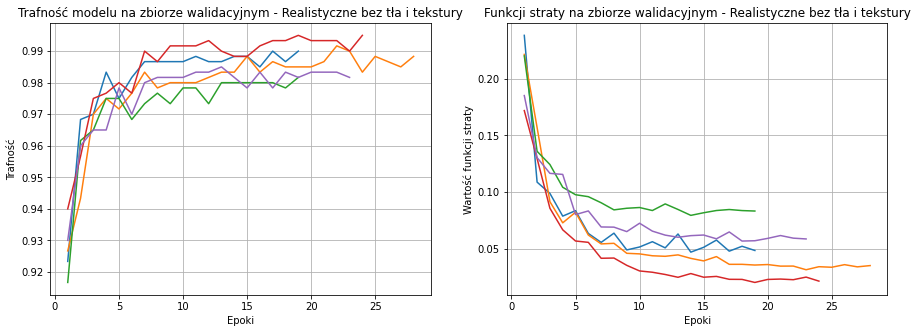

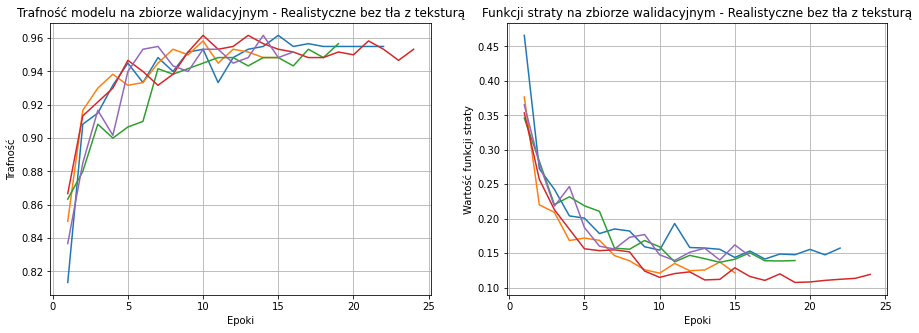

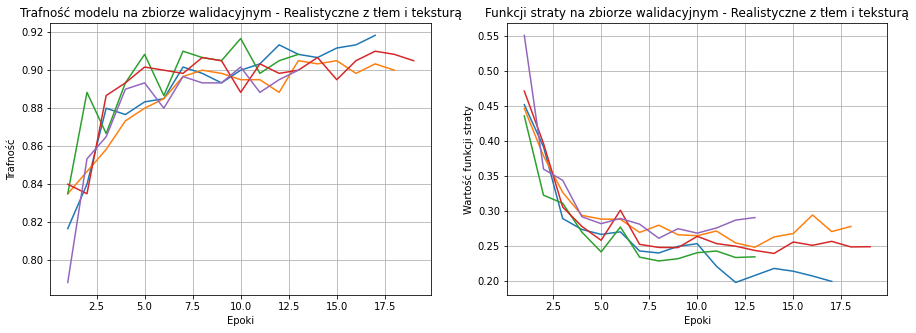

In [6]:
result_paths = ['results/STL_IMAGES_SB',
                'results/STL_IMAGES_SW',
                'results/STL_IMAGES_WB',
                'results/STL_IMAGES_WW',
                'results/STL_RENDERS_SIMPLE_NOBG',
                'results/STL_RENDERS_SIMPLE_BG',
                'results/STL_RENDERS1',
                'results/STL_RENDERS2',
                'results/STL_RENDERS3'
               ]
labels = ['Uproszczone, czarne tło', 
          'Uproszczone, białe tło', 
          'Krawędzie, czarne tło', 
          'Krawędzie, białe tło', 
          'Realistyczne z odległości bez tła', 
          'Realistyczne z odległości z tłem', 
          'Realistyczne bez tła i tekstury', 
          'Realistyczne bez tła z teksturą', 
          'Realistyczne z tłem i teksturą'
         ]
show_test_acc(result_paths, labels, 5)
show_all_acc_loss_charts(result_paths, 50, 5, labels)


## Macierze pomyłek

Uproszczone, czarne tło


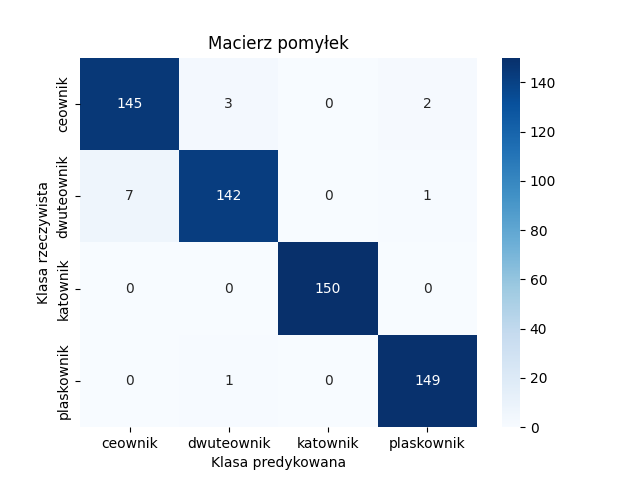

Uproszczone, białe tło


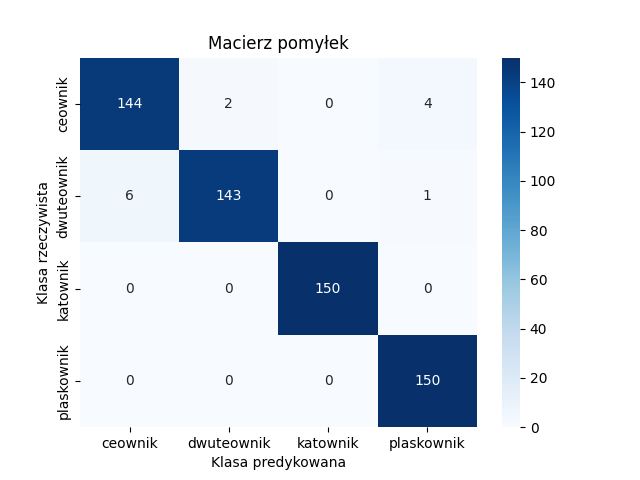

Krawędzie, czarne tło


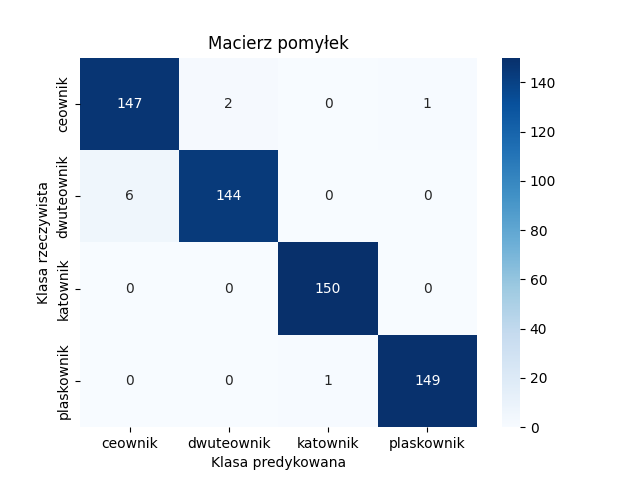

Krawędzie, białe tło


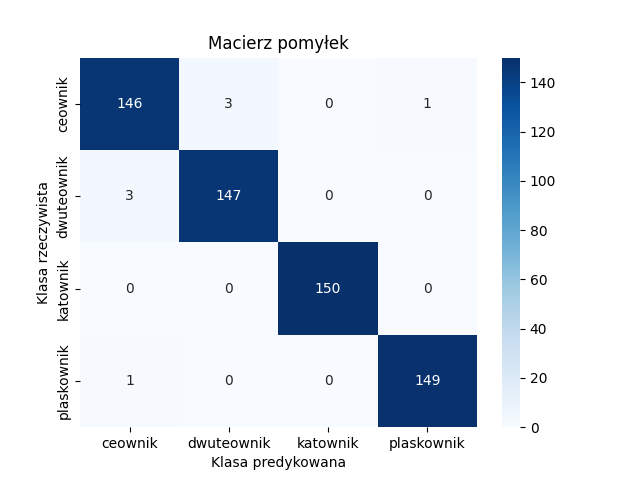

Realistyczne z odległości bez tła


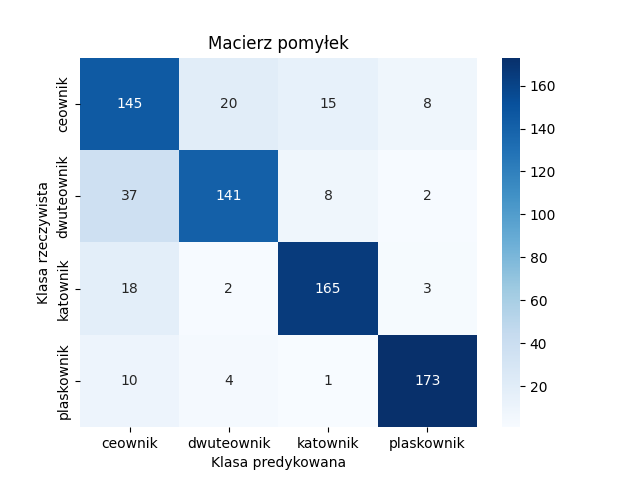

Realistyczne z odległości z tłem


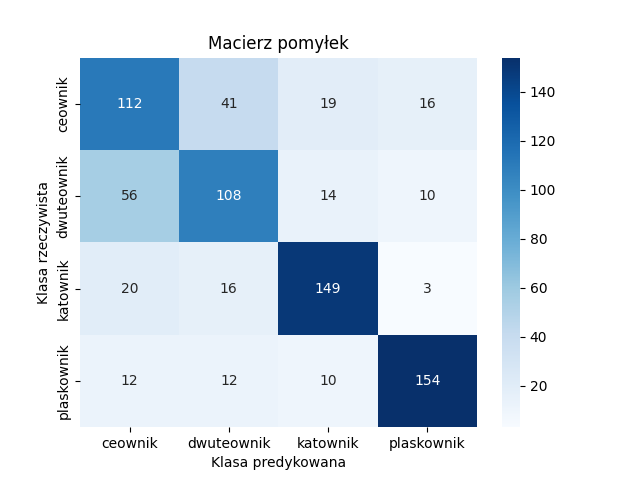

Realistyczne bez tła i tekstury


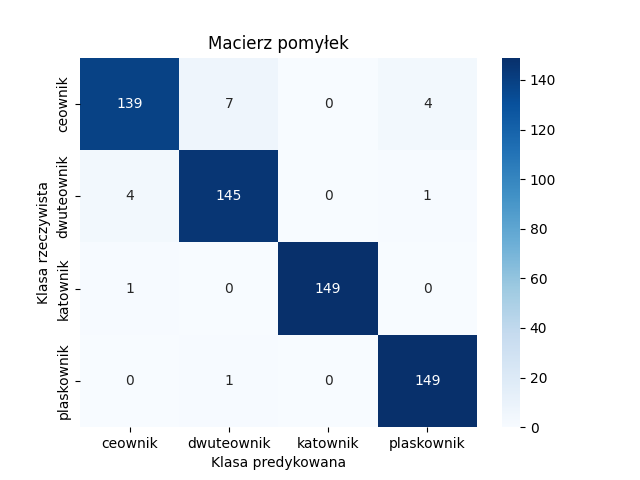

Realistyczne bez tła z teksturą


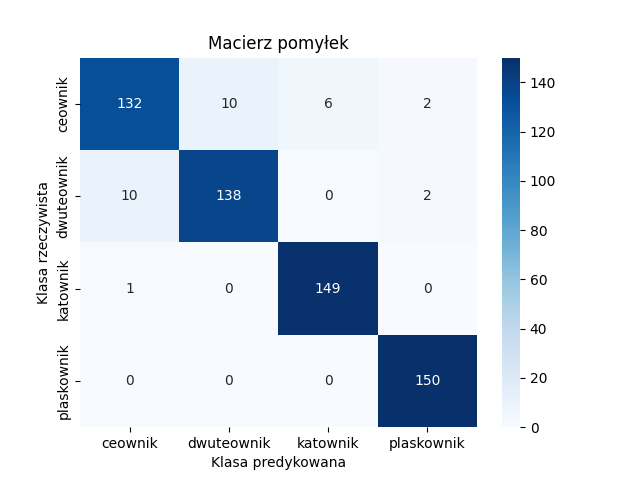

Realistyczne z tłem i teksturą


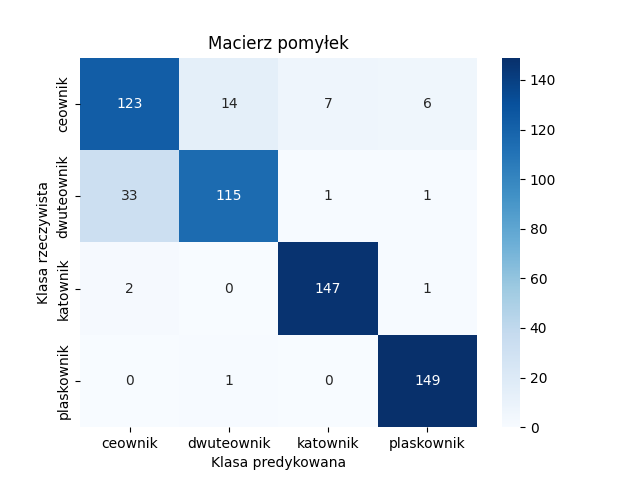

In [7]:
for path, label in zip(result_paths, labels):
    print(label)
    path = f'{path}/0_macierz_pomylek.png'
    img = Image.open(path)
    display(img)